# import

In [1]:
import os
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
import pandas_profiling as pdp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from IPython.display import display

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library 

# Setting

In [2]:
file_path = '../data/'

In [3]:
categorical_columns = [
    'chip_id',
    'exc_wl',
    'layout_a',
]

numeric_columns = [
    'layout_x',
    'layout_y',
    'pos_x',
    "params0",
    "params1",
    "params2",
    "params3",
    "params4",
    "params5",
    "params6",
    "rms",
    "beta",
    "intensity_max",
    "intensity_min",
    "intensity_std",
    "intensity_mean"
]
datetime_columns = [
]
id_columns = [
    'spectrum_id',
]
target_column = 'target'

print(f'the number of categorical columns: {len(categorical_columns)}')
print(f'the number of numeric columns: {len(numeric_columns)}')
print(f'the number of datetime columns: {len(datetime_columns)}')
print(f'target: {target_column}')
print(f'id: {id_columns}')

the number of categorical columns: 3
the number of numeric columns: 16
the number of datetime columns: 0
target: target
id: ['spectrum_id']


# Read data

In [4]:
os.listdir(file_path)

['.DS_Store',
 'atmaCup5__sample_submission.csv',
 'fitting.csv',
 'intermed',
 'test.csv',
 'train.csv',
 'spectrum_raw.zip',
 'spectrum_raw']

In [5]:
train = pd.read_csv(file_path + 'train.csv')
test =  pd.read_csv(file_path + 'test.csv')
fitting = pd.read_csv(file_path + 'fitting.csv')

train = pd.merge(train, fitting, on="spectrum_id", how="left")
test = pd.merge(test, fitting, on="spectrum_id", how="left")

print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (7436, 18)
test shape: (6952, 17)


In [6]:
train.head()

,spectrum_id,spectrum_filename,chip_id,exc_wl,layout_a,layout_x,layout_y,pos_x,target,params0,params1,params2,params3,params4,params5,params6,rms,beta
0,000da4633378740f1ee8,b2e223339f4abce9b400.dat,79ad4647da6de6425abf,850,2,36,140,1313.0810,0,30.808589,5.811802e+02,1037.714752,1.531423,22469.651641,1032.317268,8.295610,10.028668,2.521298e-02
1,000ed1a5a9fe0ad2b7dd,e2f150a503244145e7ce.dat,79ad4647da6de6425abf,780,3,0,168,159.4150,0,91.300897,1.740582e+04,1080.510452,4.766233,33257.123175,1077.468855,8.018225,7.948485,3.435612e-01
2,0016e3322c4ce0700f9a,3d58b7ccaee157979cf0.dat,c695a1e61e002b34e556,780,1,34,29,-610.7688,0,106.642946,1.000000e-10,1119.464438,2.000000,42579.867913,1378.883338,11.687417,10.739859,2.348528e-15
3,00256bd0f8c6cf5f59c8,ed3641184d3b7c0ae703.dat,c695a1e61e002b34e556,780,2,32,139,1214.6180,0,306.933674,1.099486e+04,1139.855067,5.198692,39349.741703,1145.212849,9.445029,10.379948,2.183921e-01
4,003483ee5ae313d37590,4c63418d39f86dfab9bb.dat,c695a1e61e002b34e556,780,0,45,85,-257.6161,0,46.133256,2.227622e+04,1120.918337,5.668012,31054.928673,1117.107782,7.658710,8.316550,4.176962e-01


In [7]:
import pathlib
p_temp = pathlib.Path(os.path.join(file_path, 'spectrum_raw'))

spec = []
for file in p_temp.iterdir():
    spec_df = pd.read_csv(file, sep='\t', header=None)
    spec_df.columns = ["wavelength", "intensity"] # x, y
    spec_df["spectrum_filename"] = file.stem + ".dat"
    spec.append(spec_df)

spec_df = pd.concat(spec, axis=0)
spec_df.head()

,wavelength,intensity,spectrum_filename
0,1032.836,87.0,b63e0413b6a42cfadca5.dat
1,1033.886,250.0,b63e0413b6a42cfadca5.dat
2,1034.936,293.0,b63e0413b6a42cfadca5.dat
3,1035.986,117.0,b63e0413b6a42cfadca5.dat
4,1037.036,208.0,b63e0413b6a42cfadca5.dat


In [8]:
spec_agg = spec_df.groupby("spectrum_filename")["intensity"].agg(["max", "min", "mean", "std"])
spec_agg.columns = ["intensity_" + c for c in spec_agg.columns]
spec_agg.head()

,intensity_max,intensity_min,intensity_mean,intensity_std
spectrum_filename,,,,
0001d1a608ff9c3199f5.dat,1451.0,-251.0,419.145032,238.873876
000bb292d2bd5f9b374d.dat,5265.0,-12.0,730.351562,581.602905
000d15b8980f41dddd2d.dat,7939.0,-52.0,569.412543,1047.441713
0012826a79bd771a316e.dat,1736.0,-144.0,433.380208,265.170126
001a2aee5312761dc154.dat,4763.0,-111.0,451.574653,601.305720


In [9]:
train = pd.merge(train, spec_agg.reset_index(), on="spectrum_filename", how="left")
test = pd.merge(test, spec_agg.reset_index(), on="spectrum_filename", how="left")
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (7436, 22)
test shape: (6952, 21)


# EDA

## compare train & test

### categorical columns

In [10]:
def aggregate_train_test_category(col, n_head=1000, n_tail=5):
    summary_train = train.astype({col: str}).groupby(col).size().rename('train')
    summary_test = test.astype({col: str}).groupby(col).size().rename('test')
    result = pd.concat([summary_train, summary_test], axis=1, sort=False, join='outer').fillna(0).sort_values('train', ascending=False)

    print(f'=== {col} ===')
    display(result)

In [11]:
for col in categorical_columns:
    aggregate_train_test_category(col)

=== chip_id ===


,train,test
79ad4647da6de6425abf,1821.0,0.0
118c70535bd753a86615,1805.0,0.0
84b788fdc5e779f8a0df,1194.0,0.0
6718e7f83c824b1e436d,1148.0,0.0
0b9dbf13f938efd5717f,1008.0,0.0
c695a1e61e002b34e556,460.0,0.0
3c2948d0a755e5ff99f6,0.0,3897.0
a005efe42b620a737e7e,0.0,2853.0
a948b8cdcd7957eb5c31,0.0,202.0


=== exc_wl ===


,train,test
exc_wl,,
850,4276,4190
780,3160,2762


=== layout_a ===


,train,test
layout_a,,
1,2064,1648
2,2026,1723
0,1747,1595
3,1599,1986


In [12]:

train.groupby(['chip_id', 'exc_wl', target_column])[[target_column]].agg(['count'])


target
                                    count
chip_id              exc_wl target       
0b9dbf13f938efd5717f 780    0         378
                            1           9
                     850    0         612
                            1           9
118c70535bd753a86615 780    0         799
                            1          27
                     850    0         937
                            1          42
6718e7f83c824b1e436d 780    0         575
                            1           4
                     850    0         561
                            1           8
79ad4647da6de6425abf 780    0         841
                            1          67
                     850    0         858
                            1          55
84b788fdc5e779f8a0df 850    0        1180
                            1          14
c695a1e61e002b34e556 780    0         459
                            1           1

```
不均衡データな上にデータが少ない
```

### numerical columns

### train vs test

In [19]:
def hist_train_test(col, bins=20):
    print(f'=== {col} ===')
    train[col].hist(bins=bins, alpha=0.5, density=True, label='train')
    test[col].hist(bins=bins, alpha=0.5, density=True, label='test')
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

=== layout_x ===


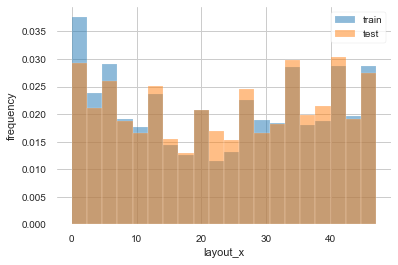

=== layout_y ===


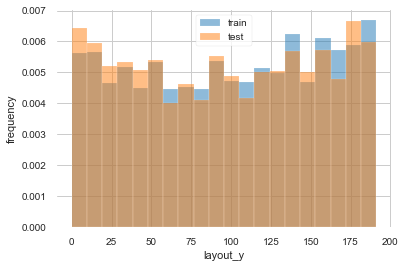

=== pos_x ===


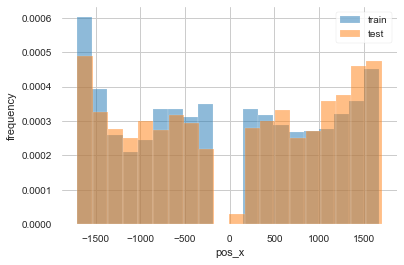

=== params0 ===


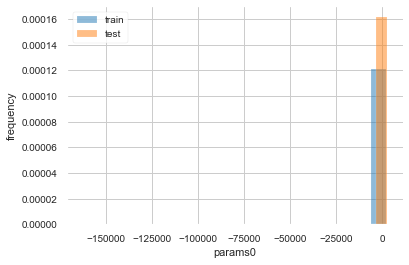

=== params1 ===


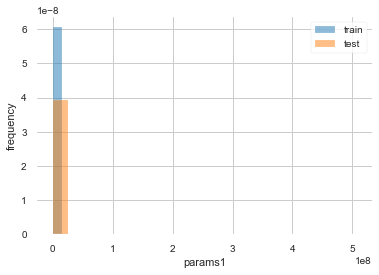

=== params2 ===


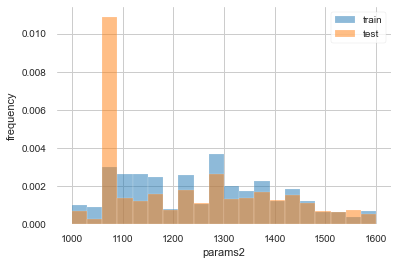

=== params3 ===


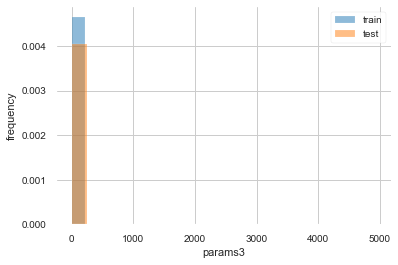

=== params4 ===


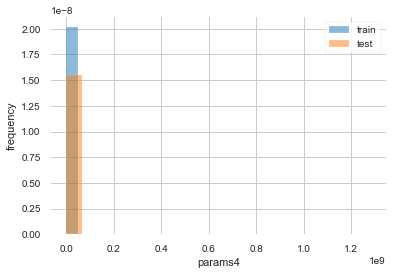

=== params5 ===


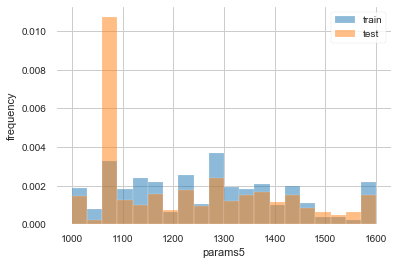

=== params6 ===


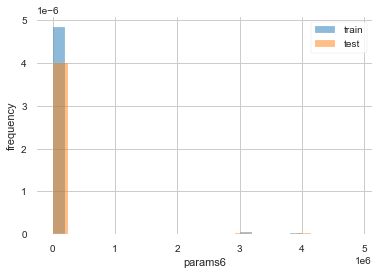

=== rms ===


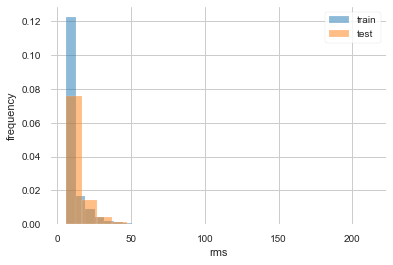

=== beta ===


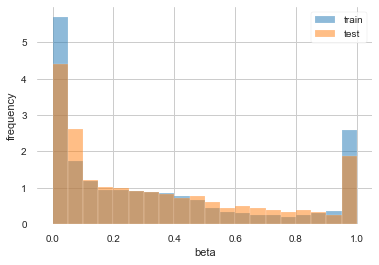

=== intensity_max ===


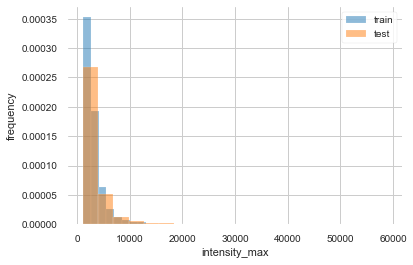

=== intensity_min ===


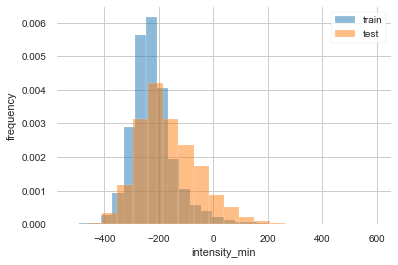

=== intensity_std ===


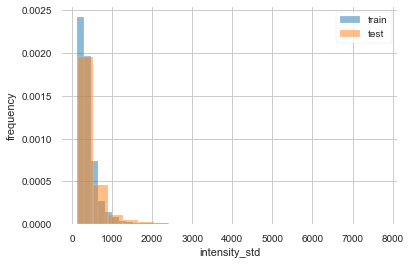

=== intensity_mean ===


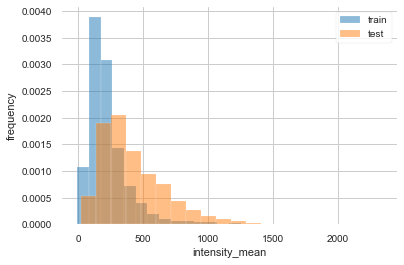

In [20]:
for col in numeric_columns:
    hist_train_test(col)

```
気になった点
・param2, 5の分布似ている
・intensityって負の値になるんだ
・pos_xって結局何？
・paramの大半は分散が低いけど、外れ値がある？(集計ミス？)
```

### True Label vs False Label

In [21]:
def hist_true_false(col, bins=20):
    print(f'=== {col} ===')
    train[train[target_column]==1][col].hist(bins=bins, alpha=0.5, density=True, label='1', color='red')
    train[train[target_column]==0][col].hist(bins=bins, alpha=0.5, density=True, label='0', color='green')
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

=== layout_x ===


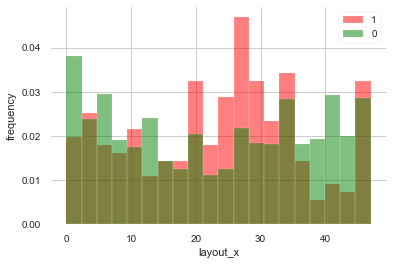

=== layout_y ===


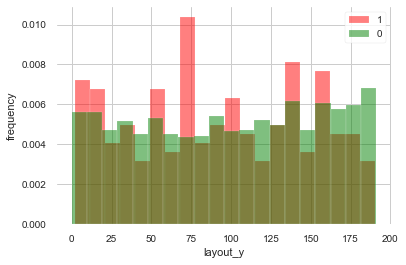

=== pos_x ===


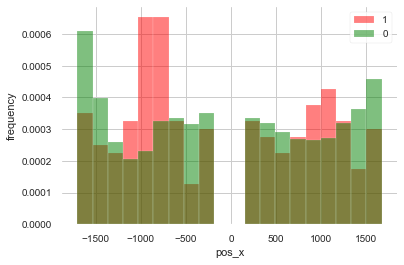

=== params0 ===


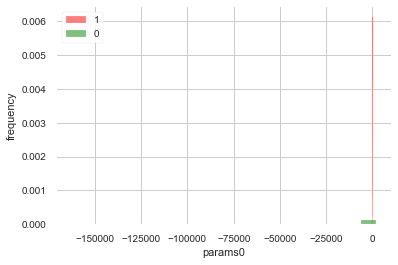

=== params1 ===


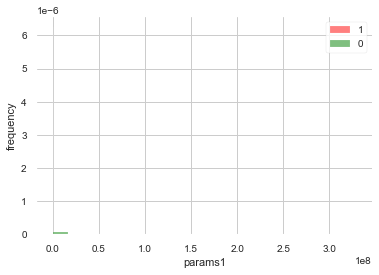

=== params2 ===


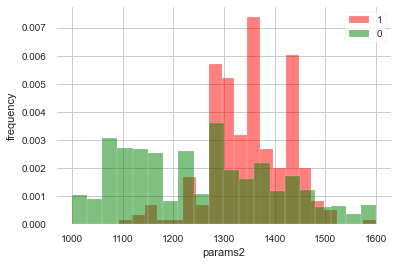

=== params3 ===


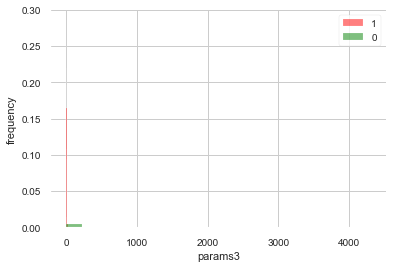

=== params4 ===


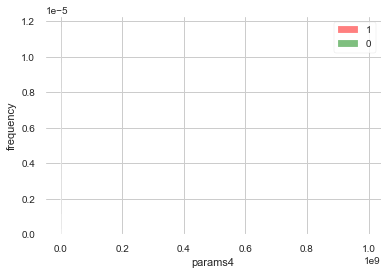

=== params5 ===


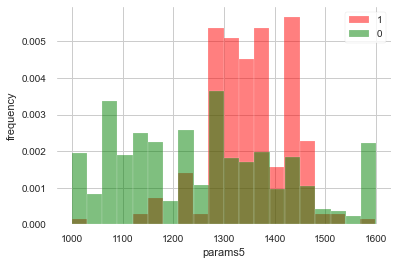

=== params6 ===


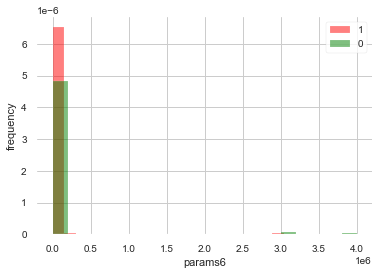

=== rms ===


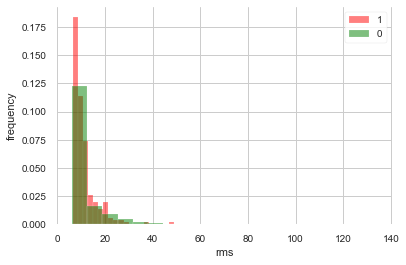

=== beta ===


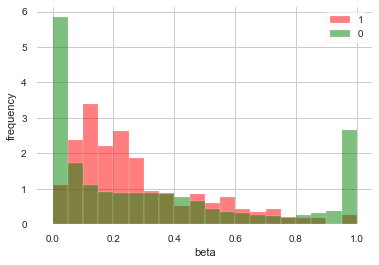

=== intensity_max ===


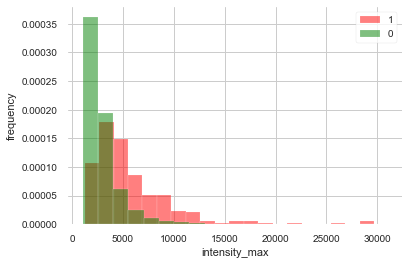

=== intensity_min ===


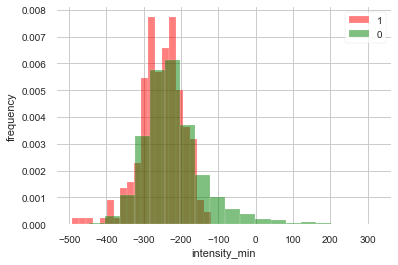

=== intensity_std ===


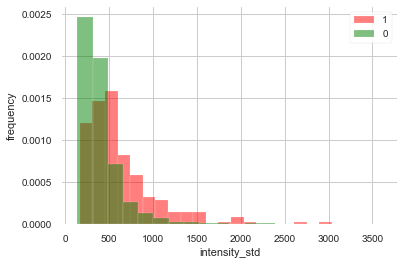

=== intensity_mean ===


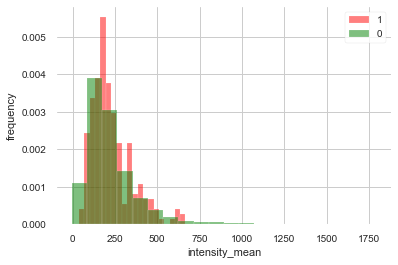

In [22]:
for col in numeric_columns:
    hist_true_false(col)

```
param1~5まであたりに大きな違いあり？
```

### vs chip_id

In [26]:
def hist_chip_id(col, chip_id: str, bins=20):
    print(f'=== {col} ===')
    train[train['chip_id']==chip_id][col].hist(bins=bins, alpha=0.5, density=True, label=chip_id, color='red')
    train[train['chip_id']!=chip_id][col].hist(bins=bins, alpha=0.5, density=True, label='other', color='green')
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

*****0b9dbf13f938efd5717f*****
=== layout_x ===


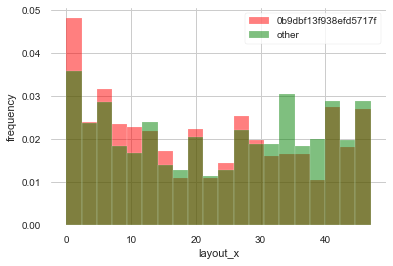

=== layout_y ===


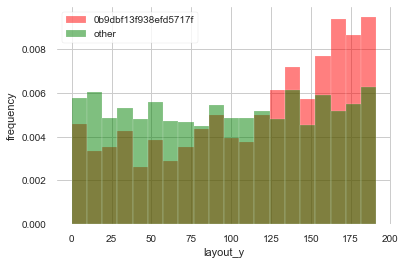

=== pos_x ===


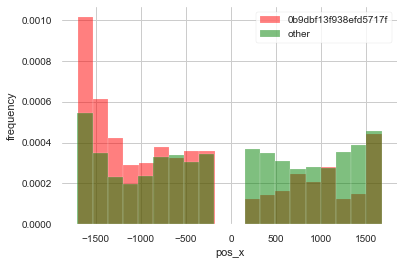

=== params0 ===


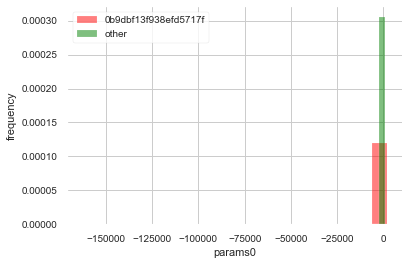

=== params1 ===


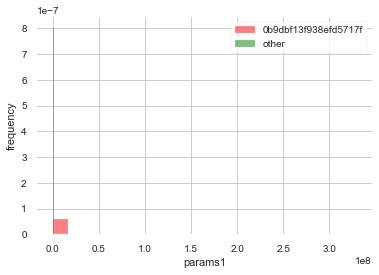

=== params2 ===


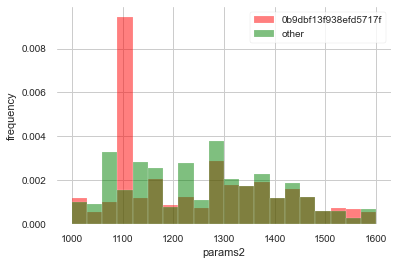

=== params3 ===


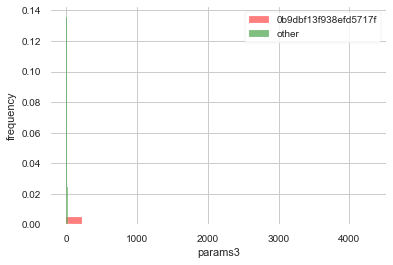

=== params4 ===


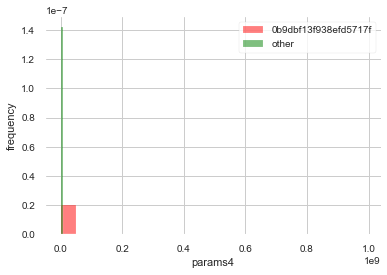

=== params5 ===


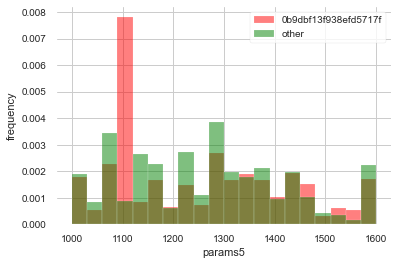

=== params6 ===


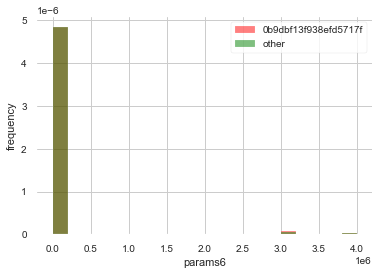

=== rms ===


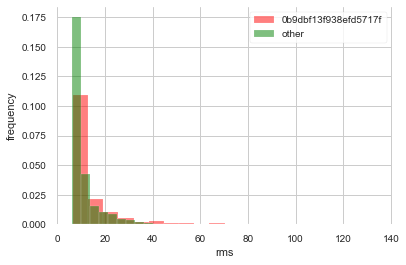

=== beta ===


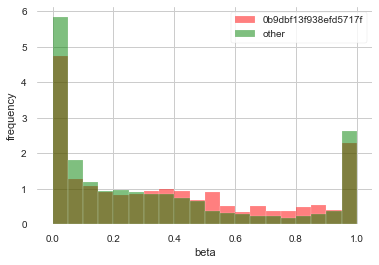

=== intensity_max ===


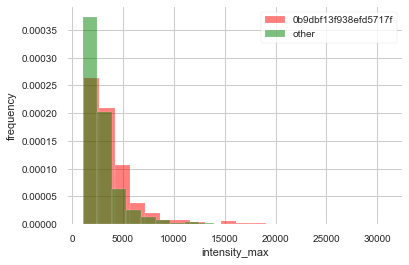

=== intensity_min ===


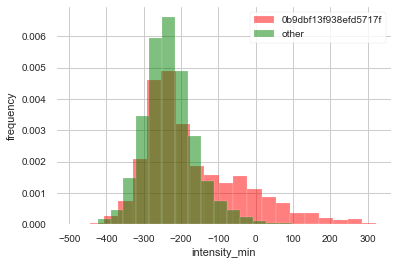

=== intensity_std ===


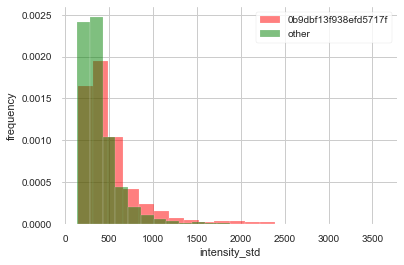

=== intensity_mean ===


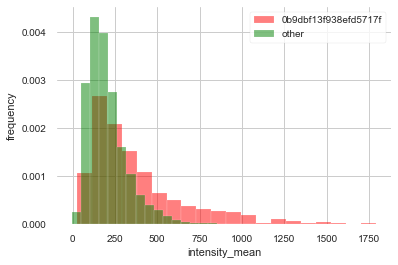

*****6718e7f83c824b1e436d*****
=== layout_x ===


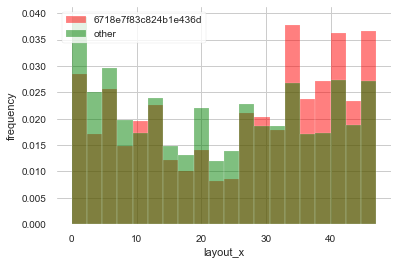

=== layout_y ===


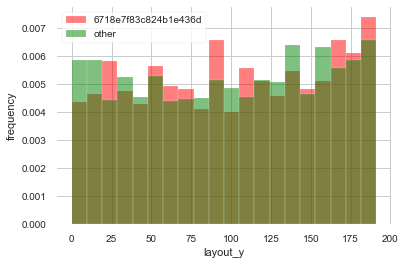

=== pos_x ===


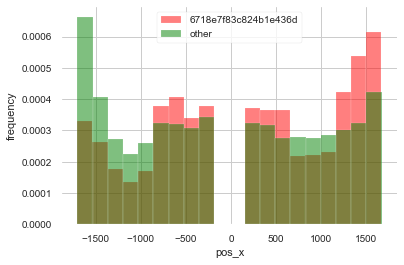

=== params0 ===


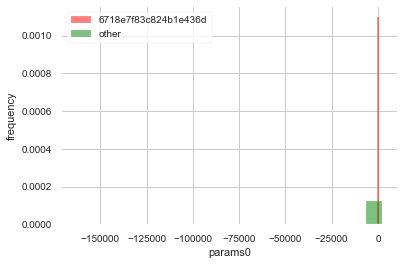

=== params1 ===


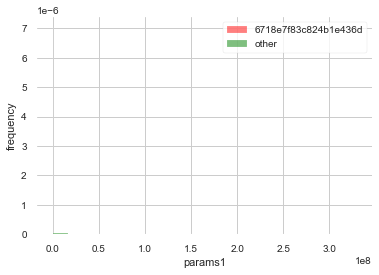

=== params2 ===


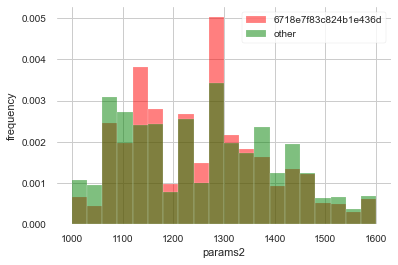

=== params3 ===


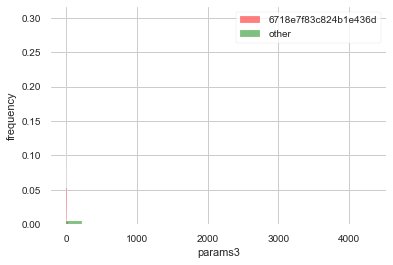

=== params4 ===


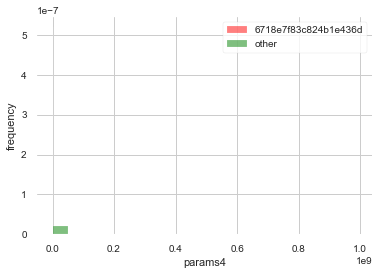

=== params5 ===


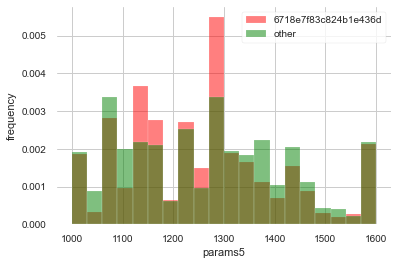

=== params6 ===


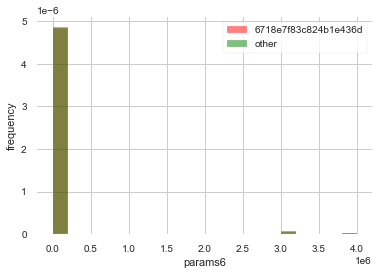

=== rms ===


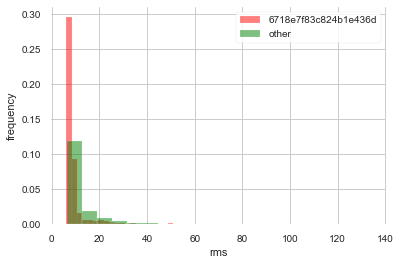

=== beta ===


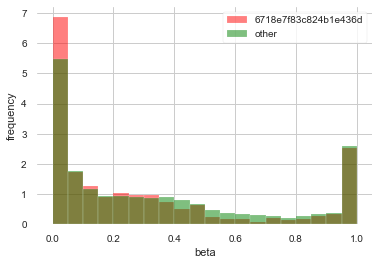

=== intensity_max ===


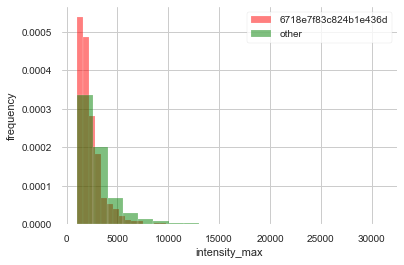

=== intensity_min ===


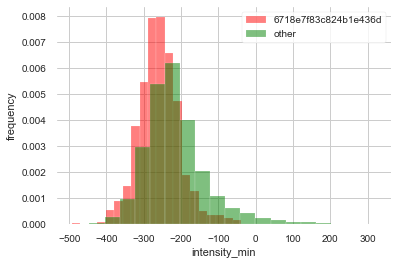

=== intensity_std ===


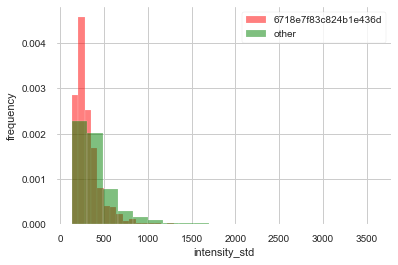

=== intensity_mean ===


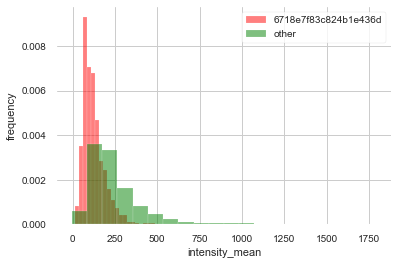

In [27]:
for chip_id in ['0b9dbf13f938efd5717f', '6718e7f83c824b1e436d']:
    print('*' * 5 + chip_id + '*'*5)
    for col in numeric_columns:
        hist_chip_id(col, chip_id)

### exc_wl

In [15]:
def hist_exc_wl(col, bins=20):
    print(f'=== {col} ===')
    train[train['exc_wl']==850][col].hist(bins=bins, alpha=0.5, density=True, label=850, color='red')
    train[train['exc_wl']!=850][col].hist(bins=bins, alpha=0.5, density=True, label=780, color='green')
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

=== layout_x ===


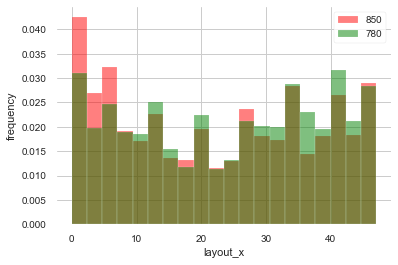

=== layout_y ===


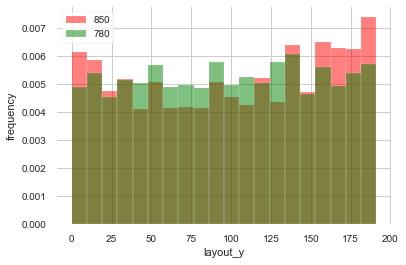

=== pos_x ===


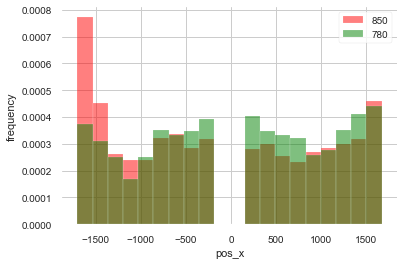

=== params0 ===


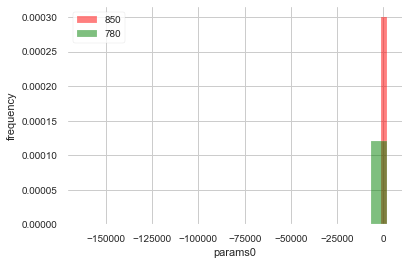

=== params1 ===


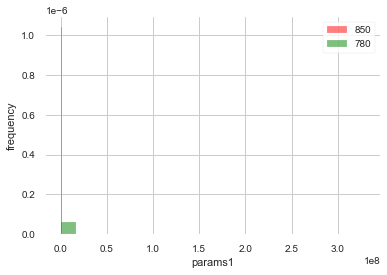

=== params2 ===


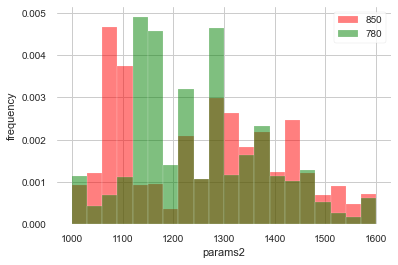

=== params3 ===


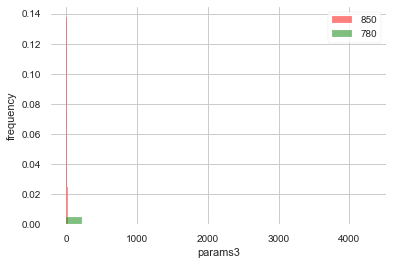

=== params4 ===


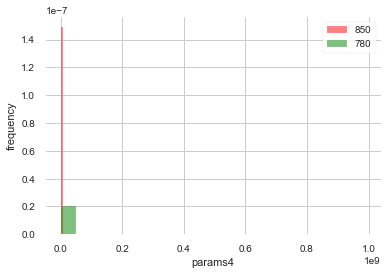

=== params5 ===


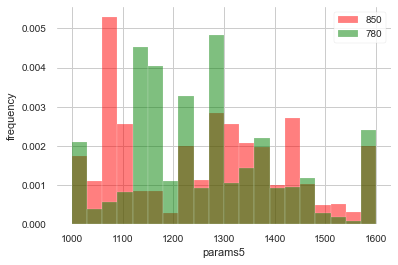

=== params6 ===


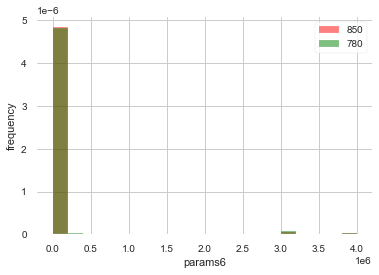

=== rms ===


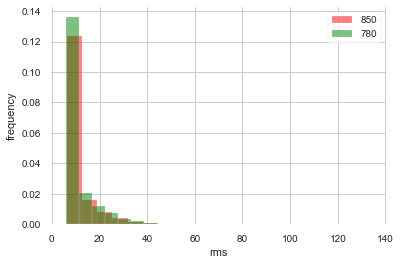

=== beta ===


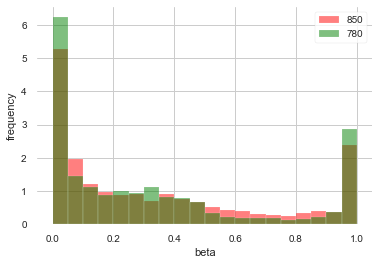

=== intensity_max ===


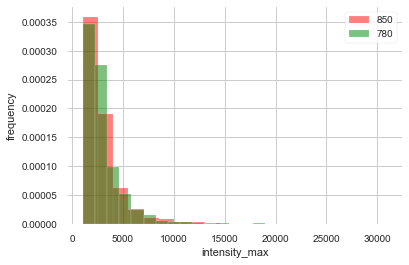

=== intensity_min ===


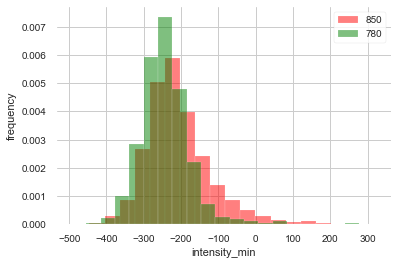

=== intensity_std ===


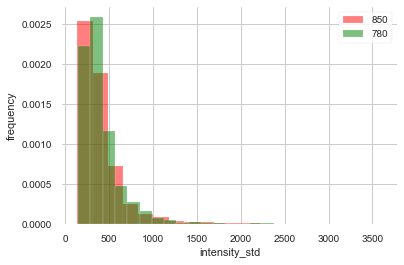

=== intensity_mean ===


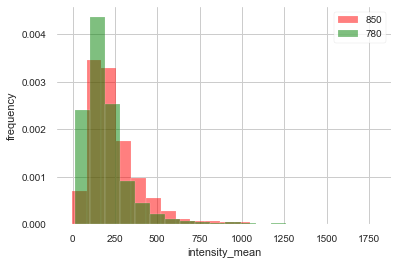

In [16]:
for col in numeric_columns:
    hist_exc_wl(col)

### unique columns

In [14]:
train.groupby('spectrum_filename').count().max()

spectrum_id       1
chip_id           1
exc_wl            1
layout_a          1
layout_x          1
layout_y          1
pos_x             1
target            1
params0           1
params1           1
params2           1
params3           1
params4           1
params5           1
params6           1
rms               1
beta              1
intensity_max     1
intensity_min     1
intensity_mean    1
intensity_std     1
dtype: int64

In [18]:
print('num spectrum_id: ', len(train.spectrum_id.unique()))
print('num spectrum_filename: ', len(train.spectrum_filename.unique()))

num spectrum_id:  7436
num spectrum_filename:  7436


## equivalent columns

### constant columns

In [19]:
def get_constant_columns(df):
    cols_list = [col for col in df.columns if df[col].nunique() == 1]
    return cols_list

In [20]:
print(f'constant columns in train: {get_constant_columns(train)}')
print(f'constant columns in test: {get_constant_columns(test)}')

constant columns in train: []
constant columns in test: []


### duplicated columns

In [21]:
def get_duplicated_columns(df):
    cols_list = []
    c = df.columns
    for i in range(len(c)-1):
        v = df[c[i]].values
        for j in range(i+1,len(c)):
            if np.array_equal(v, df[c[j]].values):
                cols_list.append(c[j])
    return cols_list

In [22]:
print(f'duplicated columns in train: {get_duplicated_columns(train)}')
print(f'duplicated columns in test: {get_duplicated_columns(test)}')

duplicated columns in train: []
duplicated columns in test: []


### new appearance in test

In [23]:
def get_new_apperance(train, test, col):
    print(f'=== {col} ===')
    train_unique = train[col].unique()
    test_unique = test[col].unique()
    new = [value for value in test_unique if value not in train_unique]
    print(new)
    return new

In [24]:
n_list = []
for col in categorical_columns:
    new = get_new_apperance(train, test, col)
    n_list.append(len(new))

=== chip_id ===
['a948b8cdcd7957eb5c31', '3c2948d0a755e5ff99f6', 'a005efe42b620a737e7e']
=== exc_wl ===
[]
=== layout_a ===
[]


In [25]:
n_list = []
for col in categorical_columns:
    new = get_new_apperance(test, train, col)
    n_list.append(len(new))

=== chip_id ===
['79ad4647da6de6425abf', 'c695a1e61e002b34e556', '6718e7f83c824b1e436d', '0b9dbf13f938efd5717f', '84b788fdc5e779f8a0df', '118c70535bd753a86615']
=== exc_wl ===
[]
=== layout_a ===
[]


```
chip_idにtrain, testで重複なし
```

# その他

In [19]:
train.groupby(['chip_id', 'exc_wl', 'target'])[['target']].count().T

chip_id 0b9dbf13f938efd5717f            118c70535bd753a86615               \
exc_wl                   780     850                     780      850       
target                     0  1    0  1                    0   1    0   1   
target                   378  9  612  9                  799  27  937  42   

chip_id 6718e7f83c824b1e436d            79ad4647da6de6425abf               \
exc_wl                   780     850                     780      850       
target                     0  1    0  1                    0   1    0   1   
target                   575  4  561  8                  841  67  858  55   

chip_id 84b788fdc5e779f8a0df     c695a1e61e002b34e556     
exc_wl                   850                      780     
target                     0   1                    0  1  
target                  1180  14                  459  1

# Model

In [109]:
remove_features = [
    "chip_id"
]

categorical_columns = [c for c in categorical_columns if c not in remove_features]
print(categorical_columns)

['exc_wl', 'layout_a']


In [110]:
# remove id columns
features = categorical_columns + numeric_columns
print(f'features: {features}')

features: ['exc_wl', 'layout_a', 'layout_x', 'layout_y', 'pos_x', 'params0', 'params1', 'params2', 'params3', 'params4', 'params5', 'params6', 'rms', 'beta', 'intensity_max', 'intensity_min', 'intensity_std', 'intensity_mean']


In [111]:
train_simple = train.copy()

for col in categorical_columns:
    le = LabelEncoder()
    train_simple[col] = le.fit_transform(list(train_simple[col].values))

display(train_simple.head())

,spectrum_id,spectrum_filename,chip_id,exc_wl,layout_a,layout_x,layout_y,pos_x,target,params0,...,params3,params4,params5,params6,rms,beta,intensity_max,intensity_min,intensity_mean,intensity_std
0,000da4633378740f1ee8,b2e223339f4abce9b400.dat,79ad4647da6de6425abf,1,2,36,140,1313.0810,0,30.808589,...,1.531423,22469.651641,1032.317268,8.295610,10.028668,2.521298e-02,1751.0,-228.0,40.292752,172.206792
1,000ed1a5a9fe0ad2b7dd,e2f150a503244145e7ce.dat,79ad4647da6de6425abf,0,3,0,168,159.4150,0,91.300897,...,4.766233,33257.123175,1077.468855,8.018225,7.948485,3.435612e-01,4219.0,-263.0,166.958984,463.428363
2,0016e3322c4ce0700f9a,3d58b7ccaee157979cf0.dat,c695a1e61e002b34e556,0,1,34,29,-610.7688,0,106.642946,...,2.000000,42579.867913,1378.883338,11.687417,10.739859,2.348528e-15,2412.0,-235.0,151.577691,327.857694
3,00256bd0f8c6cf5f59c8,ed3641184d3b7c0ae703.dat,c695a1e61e002b34e556,0,2,32,139,1214.6180,0,306.933674,...,5.198692,39349.741703,1145.212849,9.445029,10.379948,2.183921e-01,3209.0,-52.0,523.080947,436.481410
4,003483ee5ae313d37590,4c63418d39f86dfab9bb.dat,c695a1e61e002b34e556,0,0,45,85,-257.6161,0,46.133256,...,5.668012,31054.928673,1117.107782,7.658710,8.316550,4.176962e-01,3998.0,-245.0,138.187717,472.009931


In [112]:
lgb_model_params = {
    'objective': 'binary',
    'metric': 'binary',
    'boosting': 'gbdt',
    'max_depth': 5,
    'num_leaves': 50,
    'learning_rate': 0.1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'subsample_freq': 1,
    'seed': 71,
    'bagging_seed': 71,
    'feature_fraction_seed': 71,
    'drop_seed': 71,
    'verbose': -1
}

lgb_train_params = {
    'num_boost_round': 1000,
    'early_stopping_rounds': 100,
    'verbose_eval': 50
}

In [113]:
train_set, val_set = train_test_split(train_simple, test_size=0.33, random_state=71, shuffle=True)
x_train = train_set[features]
y_train = np.log1p(train_set[target_column]) # 1-> 0.697..., 0-> 0
x_val = val_set[features]
y_val = np.log1p(val_set[target_column])
print(f'the number of train set: {len(x_train)}')
print(f'the number of valid set: {len(x_val)}')

train_lgb = lgb.Dataset(x_train, label=y_train)
val_lgb = lgb.Dataset(x_val, label=y_val)

clf = lgb.train(
    lgb_model_params,
    train_lgb,
    valid_sets=[train_lgb, val_lgb],
    valid_names=['train', 'valid'],
    categorical_feature=categorical_columns,
    **lgb_train_params
)

the number of train set: 4982
the number of valid set: 2454
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.013432	valid's binary_logloss: 0.0489684


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['exc_wl', 'layout_a']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	train's binary_logloss: 0.00333496	valid's binary_logloss: 0.0506997
[150]	train's binary_logloss: 0.00101108	valid's binary_logloss: 0.0573426
Early stopping, best iteration is:
[65]	train's binary_logloss: 0.00836379	valid's binary_logloss: 0.0471936


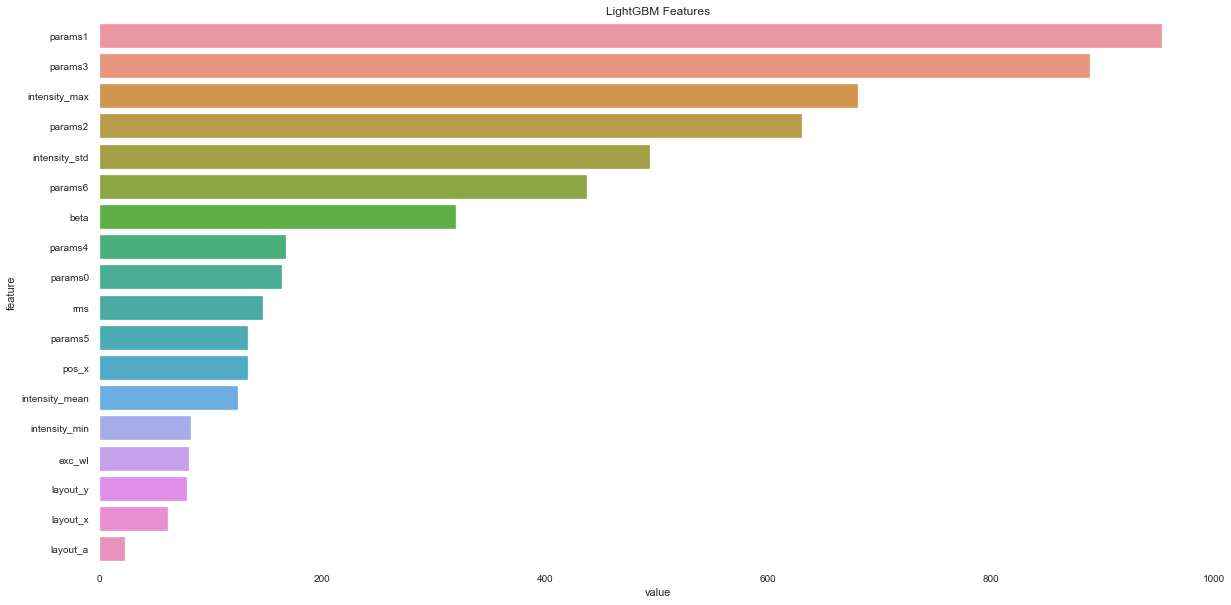

In [114]:
feature_imp = pd.DataFrame(
    sorted(zip(clf.feature_importance(importance_type='gain'), features)), columns=['value', 'feature']
)

plt.figure(figsize=(20, 10))
sns.barplot(x='value', y='feature', data=feature_imp.sort_values(by='value', ascending=False).head(20))
plt.title('LightGBM Features')
# plt.tight_layout()
plt.show()

## adversarial validation

In [115]:
# remove id columns
features = [col for col in test.columns if col not in id_columns]
categorical_columns = [c for c in categorical_columns if c not in remove_features]
features = categorical_columns + numeric_columns
print(f'features: {features}')

features: ['exc_wl', 'layout_a', 'layout_x', 'layout_y', 'pos_x', 'params0', 'params1', 'params2', 'params3', 'params4', 'params5', 'params6', 'rms', 'beta', 'intensity_max', 'intensity_min', 'intensity_std', 'intensity_mean']


In [116]:
train_adv = train[features]
train_adv['target'] = 0
test_adv = test[features]
test_adv['target'] = 1

train_test_adv = pd.concat([train_adv, test_adv], axis=0, sort=False).reset_index(drop=True)
target = train_test_adv['target'].values

display(train_test_adv.head())
display(train_test_adv.tail())

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,exc_wl,layout_a,layout_x,layout_y,pos_x,params0,params1,params2,params3,params4,params5,params6,rms,beta,intensity_max,intensity_min,intensity_std,intensity_mean,target
0,850,2,36,140,1313.0810,30.808589,5.811802e+02,1037.714752,1.531423,22469.651641,1032.317268,8.295610,10.028668,2.521298e-02,1751.0,-228.0,172.206792,40.292752,0
1,780,3,0,168,159.4150,91.300897,1.740582e+04,1080.510452,4.766233,33257.123175,1077.468855,8.018225,7.948485,3.435612e-01,4219.0,-263.0,463.428363,166.958984,0
2,780,1,34,29,-610.7688,106.642946,1.000000e-10,1119.464438,2.000000,42579.867913,1378.883338,11.687417,10.739859,2.348528e-15,2412.0,-235.0,327.857694,151.577691,0
3,780,2,32,139,1214.6180,306.933674,1.099486e+04,1139.855067,5.198692,39349.741703,1145.212849,9.445029,10.379948,2.183921e-01,3209.0,-52.0,436.481410,523.080947,0
4,780,0,45,85,-257.6161,46.133256,2.227622e+04,1120.918337,5.668012,31054.928673,1117.107782,7.658710,8.316550,4.176962e-01,3998.0,-245.0,472.009931,138.187717,0


,exc_wl,layout_a,layout_x,layout_y,pos_x,params0,params1,params2,params3,params4,params5,params6,rms,beta,intensity_max,intensity_min,intensity_std,intensity_mean,target
14383,850,3,2,114,220.9971,150.351050,1575.743737,1087.530221,0.500000,11981.831643,1085.864281,5.739515,9.893204,0.116226,1650.0,-148.0,247.617231,327.153512,1
14384,780,3,16,181,702.8404,285.044749,5157.487766,1153.698321,4.533969,16558.324763,1149.558122,6.347408,19.912753,0.237499,2159.0,-100.0,379.261253,371.267361,1
14385,780,1,25,39,-897.3608,201.594580,1298.787359,1137.037932,4.397521,48307.445699,1162.600089,10.304924,8.347038,0.026182,3164.0,-183.0,383.777055,267.291368,1
14386,780,0,3,95,-1599.4280,986.415682,1536.973685,1155.252414,2.437632,14780.391432,1154.479281,17.361207,9.972497,0.094193,1994.0,25.0,370.821713,951.654080,1
14387,850,3,28,10,1057.1280,48.644496,446.157645,1552.515469,0.500000,54420.981053,1559.177089,14.477710,9.881024,0.008132,2420.0,-204.0,334.496002,141.838226,1


In [117]:
for col in categorical_columns:
    le = LabelEncoder()
    train_test_adv[col] = le.fit_transform(list(train_test_adv[col].values))

display(train_test_adv.head())

,exc_wl,layout_a,layout_x,layout_y,pos_x,params0,params1,params2,params3,params4,params5,params6,rms,beta,intensity_max,intensity_min,intensity_std,intensity_mean,target
0,1,2,36,140,1313.0810,30.808589,5.811802e+02,1037.714752,1.531423,22469.651641,1032.317268,8.295610,10.028668,2.521298e-02,1751.0,-228.0,172.206792,40.292752,0
1,0,3,0,168,159.4150,91.300897,1.740582e+04,1080.510452,4.766233,33257.123175,1077.468855,8.018225,7.948485,3.435612e-01,4219.0,-263.0,463.428363,166.958984,0
2,0,1,34,29,-610.7688,106.642946,1.000000e-10,1119.464438,2.000000,42579.867913,1378.883338,11.687417,10.739859,2.348528e-15,2412.0,-235.0,327.857694,151.577691,0
3,0,2,32,139,1214.6180,306.933674,1.099486e+04,1139.855067,5.198692,39349.741703,1145.212849,9.445029,10.379948,2.183921e-01,3209.0,-52.0,436.481410,523.080947,0
4,0,0,45,85,-257.6161,46.133256,2.227622e+04,1120.918337,5.668012,31054.928673,1117.107782,7.658710,8.316550,4.176962e-01,3998.0,-245.0,472.009931,138.187717,0


In [118]:
lgb_model_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'max_depth': 5,
    'num_leaves': 50,
    'learning_rate': 0.1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'subsample_freq': 1,
    'seed': 71,
    'bagging_seed': 71,
    'feature_fraction_seed': 71,
    'drop_seed': 71,
    'verbose': -1
}

lgb_train_params = {
    'num_boost_round': 1000,
    'early_stopping_rounds': 100,
    'verbose_eval': 50
}

In [119]:
train_set, val_set = train_test_split(train_test_adv, test_size=0.33, random_state=71, shuffle=True)
x_train = train_set[features]
y_train = train_set['target']
x_val = val_set[features]
y_val = val_set['target']
print(f'the number of train set: {len(x_train)}')
print(f'the number of valid set: {len(x_val)}')

train_lgb = lgb.Dataset(x_train, label=y_train)
val_lgb = lgb.Dataset(x_val, label=y_val)

clf_adv = lgb.train(
    lgb_model_params,
    train_lgb,
    valid_sets=[train_lgb, val_lgb],
    valid_names=['train', 'valid'],
    #categorical_feature=categorical_columns,
    **lgb_train_params
)

the number of train set: 9639
the number of valid set: 4749
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.907658	valid's auc: 0.869026
[100]	train's auc: 0.936388	valid's auc: 0.874644
[150]	train's auc: 0.955568	valid's auc: 0.876742
[200]	train's auc: 0.968195	valid's auc: 0.877678
[250]	train's auc: 0.978173	valid's auc: 0.877013
Early stopping, best iteration is:
[186]	train's auc: 0.965215	valid's auc: 0.878356


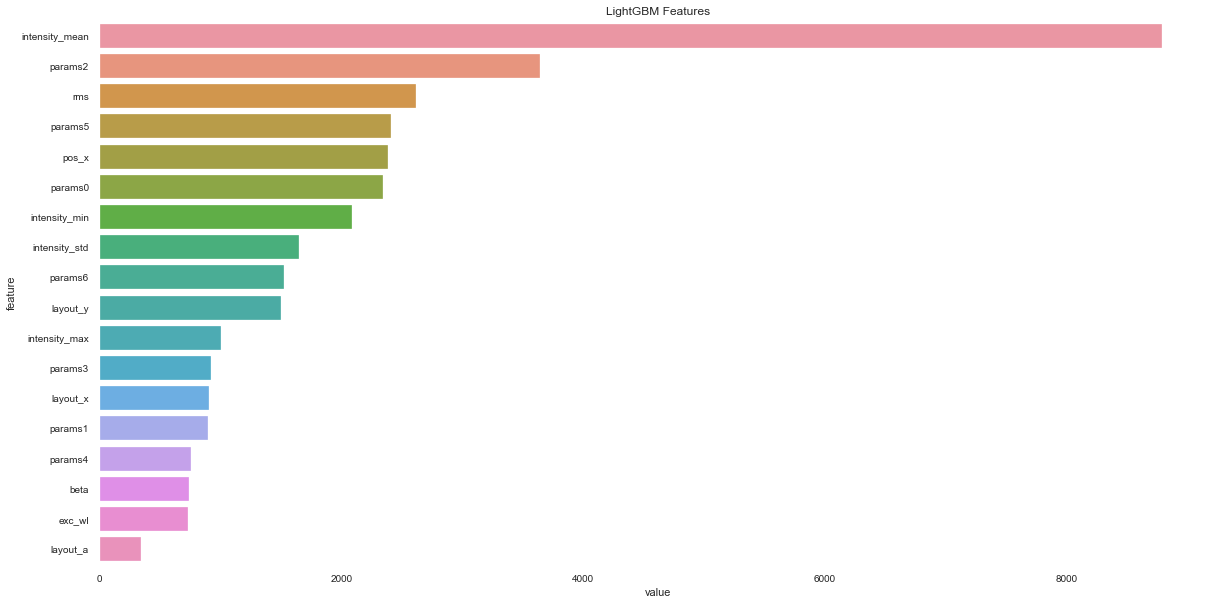

In [120]:
feature_imp = pd.DataFrame(
    sorted(zip(clf_adv.feature_importance(importance_type='gain'), features)), columns=['value', 'feature']
)

plt.figure(figsize=(20, 10))
sns.barplot(x='value', y='feature', data=feature_imp.sort_values(by='value', ascending=False).head(20))
plt.title('LightGBM Features')
# plt.tight_layout()
plt.show()

# Submit

In [130]:
pred = clf.predict(test[features])

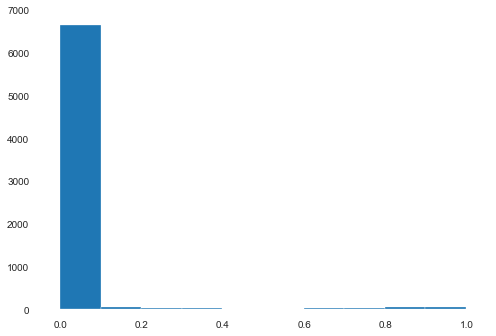

In [131]:
plt.hist(pred)
plt.show()

In [108]:
sub = pd.read_csv(file_path + 'atmaCup5__sample_submission.csv')
sub.head()

,target
0,0.355519
1,0.747361
2,0.181549
3,0.020896
4,0.043246


In [133]:
sub['target'] = pred
sub.head()

,target
0,0.000109
1,0.000211
2,0.000406
3,0.000401
4,0.000587


In [143]:
import datetime
now = datetime.datetime.now()
now = now.strftime("%m%d_%H%M%S")
sub.to_csv(f'../output/submission_{now}.csv', index=False)